<center><h1>DIP ASSIGNMENT - 4</h1></center>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def im2col(A, sz):
    m, n = A.shape
    s1, s2 = A.strides
    rows = m-sz[0]+1
    cols = n-sz[1]+1
    shp = sz[0],sz[1],rows,cols
    strd = s1,s2,s1,s2

    out = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out.reshape(sz[0]*sz[1],-1)[:,::1]

In [3]:
def showImages(img, out, str1 = 'Original Image', str2 = "Result", str3 = 'gray'):
    arr = plt.subplots(1,2, figsize =(15,15))[1]
    arr[0].imshow(img, cmap = 'gray')
    arr[0].set_title(str1)
    arr[1].imshow(out, str3)
    arr[1].set_title(str2)
    plt.show()

# Question1

In [4]:
def skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss, val = 1):
    img = np.where(img < 128 , val, val ^ 1)
    thresh = img.copy()
    it = 0
    while(True):
        it += 1
        print("Iteration -> ", it, end = '\r')
        prev = np.copy(img)
        for i in range(4):
            img = img ^ conv_hom(img, s1_hit, s1_miss)
            img = img ^ conv_hom(img, s2_hit, s2_miss)
            s1_hit = np.rot90(s1_hit)
            s1_miss = np.rot90(s1_miss)
            s2_hit = np.rot90(s2_hit)
            s2_miss = np.rot90(s2_miss)
        if np.allclose(prev, img):
            break
    showImages(thresh, img, "Binary Image", "Skeletonized")

In [5]:
def conv_hom(im, hit_k, miss_k):
    r, c = im.shape
    im = np.pad(im, ((1, 1), (1, 1)), 'constant', constant_values=(0, 0))
    ker_hit = hit_k.reshape(hit_k.shape[0]*hit_k.shape[1], 1)
    hit_val = np.sum(ker_hit)
    ker_miss = miss_k.reshape(miss_k.shape[0]*miss_k.shape[1], 1)
    mat = im2col(im, (3, 3))
    
#     ones where we hit
    ot1 = np.matmul(ker_hit.T, mat)
    ot1 = np.where(ot1 == hit_val, 1, 0)
#     ones where we miss
    ot2 = np.matmul(ker_miss.T, mat)
    ot2 = np.where(ot2 == 0, 1, 0)
    
    out = np.multiply(ot1, ot2)
    return out.reshape((r, c))

In [6]:
s1_hit = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]])
s2_hit = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]])
s1_miss = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]])
s2_miss = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])

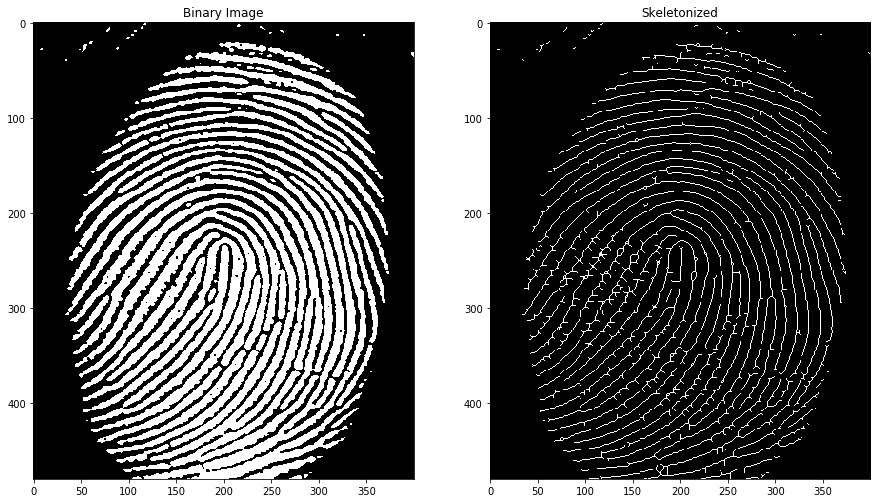

In [7]:
img = cv2.imread('./res/finger.jpg', 0)
skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss)

## Q1.2)

- S1: To detect edges and other curves which are close to being edge, curves etc. 
- S2: We use this structuring element to detect right angled triangles

## Q1.3)

1. Rotation by 90 is required to detect horizontal and vector edges and right hand corners.
2. More iterations give thinner result. Hence more iterations thinner the skeleton.

## Q1.4)

## Image of solid body

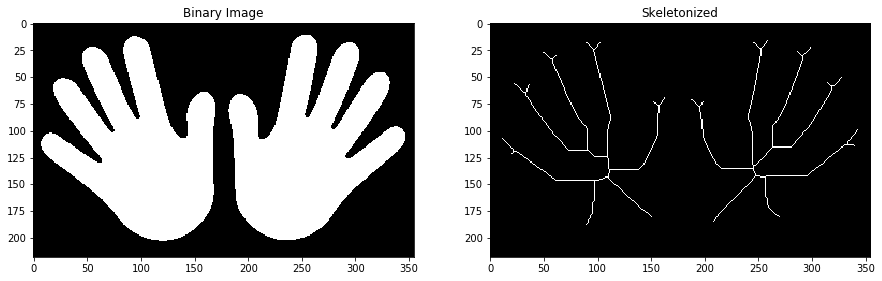

In [8]:
img = cv2.imread('./res/hand.jpg', 0)
skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss, 0)

> Explanation: For a solid object, we are getting the basic structure of the object which is completely connected

## Image with holes

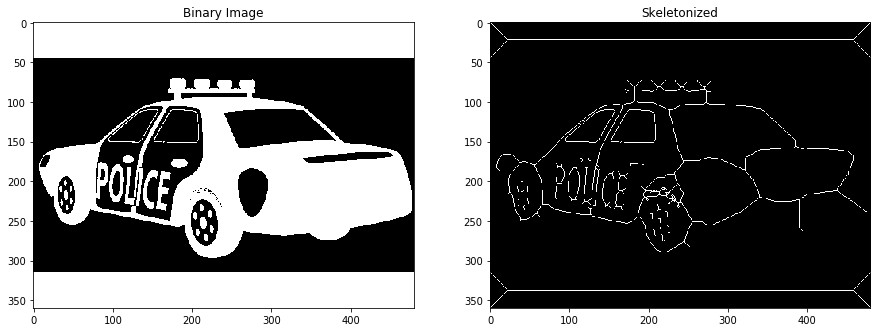

In [9]:
img = cv2.imread('./res/car.jpg', 0)
skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss)

> Explanation : We get different components and the skeleton changes because of the holes

## Thin Image

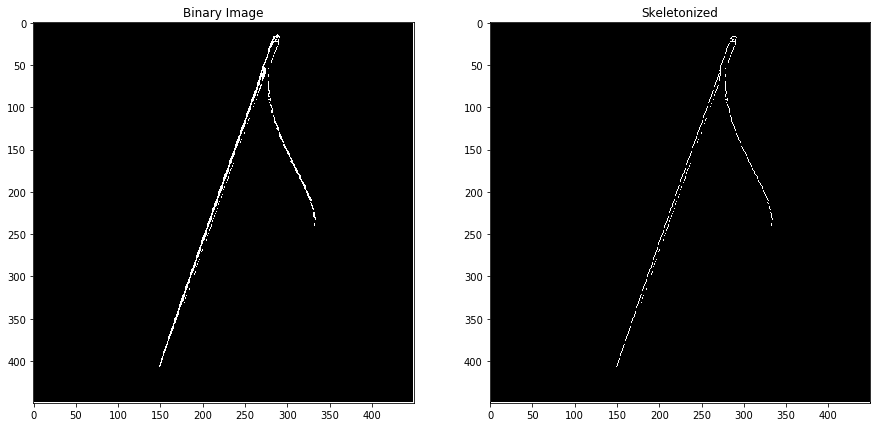

In [10]:
img = cv2.imread('./res/needle.jpg', 0)
skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss, 0)

> Explanation: As the object is already very thin, the skeleton is almost the same.

## Irregular Object

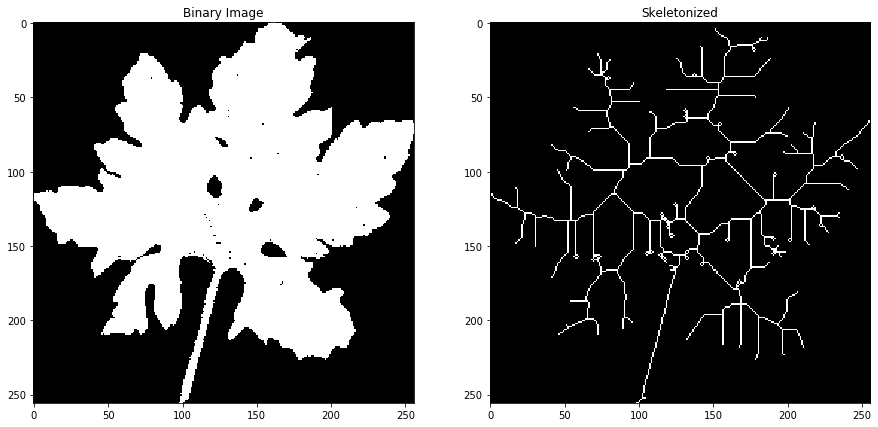

In [11]:
img = cv2.imread('./res/leaf.jpg', 0)
img = cv2.resize(img, (256, 256))
skeletonize(img, s1_hit, s1_miss, s2_hit, s2_miss)

> Explanation : For an irregular shaped object, we get a proper skeleton.

# Question 2

In [12]:
def get_neighbours(img, i, j):
    nbx = []
    nby = []
    if (i-1) >= 0 and (j+1) < img.shape[1] and img[i-1][j+1]:
        nbx.append(i-1)
        nby.append(j+1)
    if (i-1) >= 0 and (j-1) >= 0 and img[i-1][j-1]:
        nbx.append(i-1)
        nby.append(j-1)
    if (i-1) >= 0 and img[i-1][j]:
        nbx.append(i-1)
        nby.append(j)
    if (j-1) >= 0 and img[i][j-1]:
        nbx.append(i)
        nby.append(j-1)
    return (nbx, nby)

In [13]:
class dsu():

    def __init__(self):
        self.labels = [-1]

    def union(self, x, y):
        par_x = self.findParent(x)
        par_y = self.findParent(y)
        if par_x != par_y:
            self.labels[par_x] = par_y

    def findParent(self, x):
        if self.labels[x] == -1:
            return x
        else:
            return self.findParent(self.labels[x])
    def get_ct(self):
        self.labels = np.array(self.labels)
        return np.uint(np.where(self.labels == -1)[0])

In [14]:
def connected_components(im):
    Lab = np.uint(np.zeros((im.shape[0], im.shape[1])))
    n_lab = 1
    obj = dsu();
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] == 0:
                continue
            nb = get_neighbours(im, i, j)
            if len(nb[0]) > 0:
                Lab[i, j] = min(Lab[nb])
                for k in range(len(nb[0])):
                    obj.union(Lab[nb[0][k]][nb[1][k]], Lab[i, j])
            else:
                obj.labels.append(-1)
                Lab[i, j] = n_lab
                n_lab += 1
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):   
            if im[i, j]:
                Lab[i, j] = obj.findParent(Lab[i][j])
    
    return Lab, obj.get_ct()

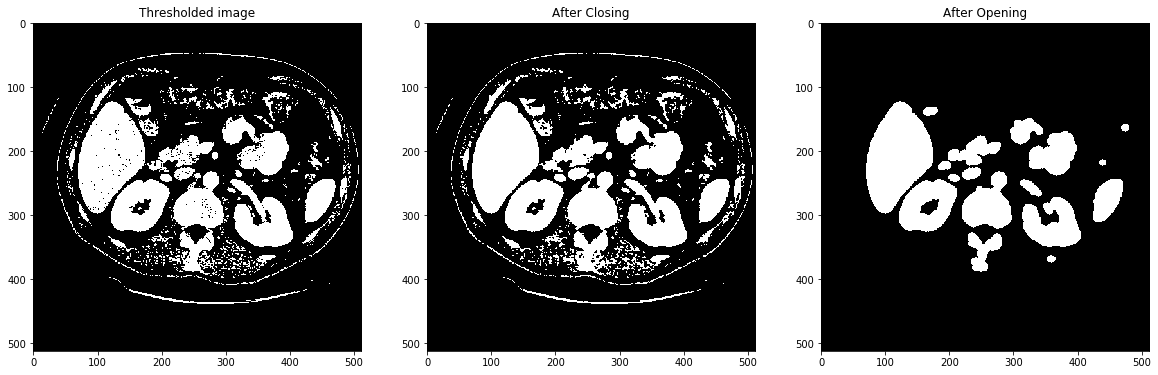

In [15]:
img = cv2.imread('./res/kidney.jpg', 0)

thresh = np.uint8(np.where(img > 130, 1, 0))

ker_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11, 11))
ker_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, ker_close)
opening = cv2.morphologyEx(close, cv2.MORPH_OPEN, ker_open)

arr = plt.subplots(1,3,figsize =(20, 20))[1]
arr[0].imshow(thresh, 'gray')
arr[0].set_title("Thresholded image")
arr[1].imshow(close, 'gray')
arr[1].set_title("After Closing")
arr[2].imshow(opening, 'gray')
arr[2].set_title("After Opening")
plt.show()

In [16]:
colors = [[255, 0, 0],
          [0, 255, 0],
          [0, 0, 255],
          [255, 255, 0],
          [255, 0, 255],
          [0, 255, 255],
          [31, 73, 125], 
          [0, 176, 80], 
          [112, 48, 160]]

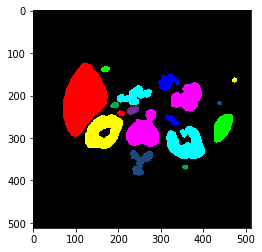

In [17]:
ret, labs = connected_components(opening)
out = np.dstack((ret, ret))
out = np.dstack((out, ret))

for i in range(len(labs)):
    ind = np.where(ret == labs[i])
    if i == 0:
        out[ind] = [0, 0, 0]
    else:
        out[ind] = colors[(i-1)%9]
plt.imshow(out)
plt.show()

# Question 3

In [18]:
img = cv2.imread('./res/coins.jpg', 0)
thresh = np.uint8(np.where(img > 128, 1, 0))

ker_disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21, 21))

ker_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, ker_open)

## Q3.1)

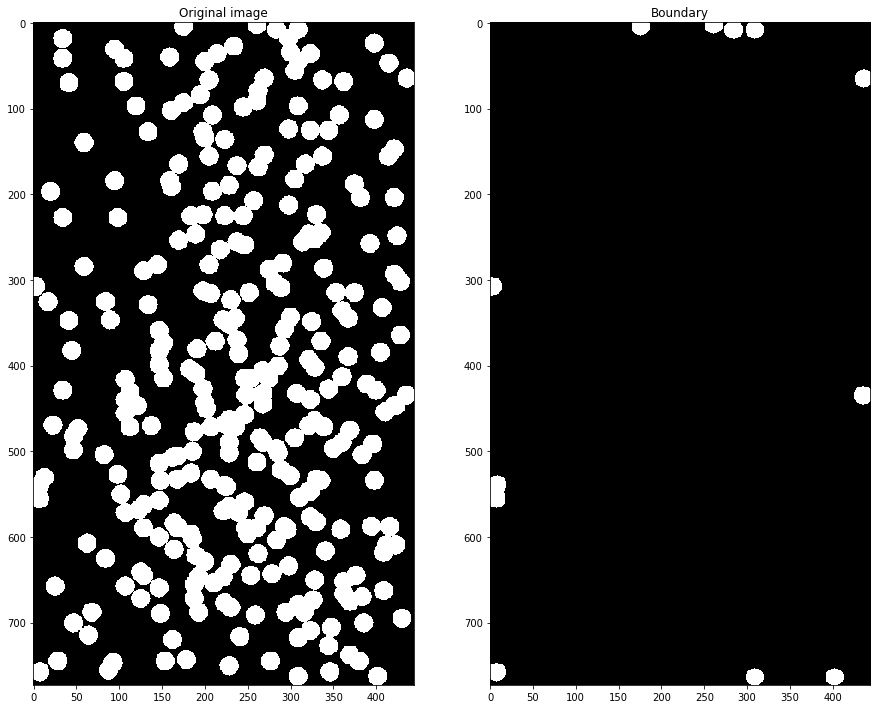

In [19]:
er = cv2.erode(thresh, ker_disk)
er[10:-10, 10:-10] = 0
dil = cv2.dilate(er, ker_disk)
showImages(thresh, dil, "Original image", "Boundary")

In [20]:
ret, labs = connected_components(thresh)
print(labs.shape)

(130,)


## Q3.2)

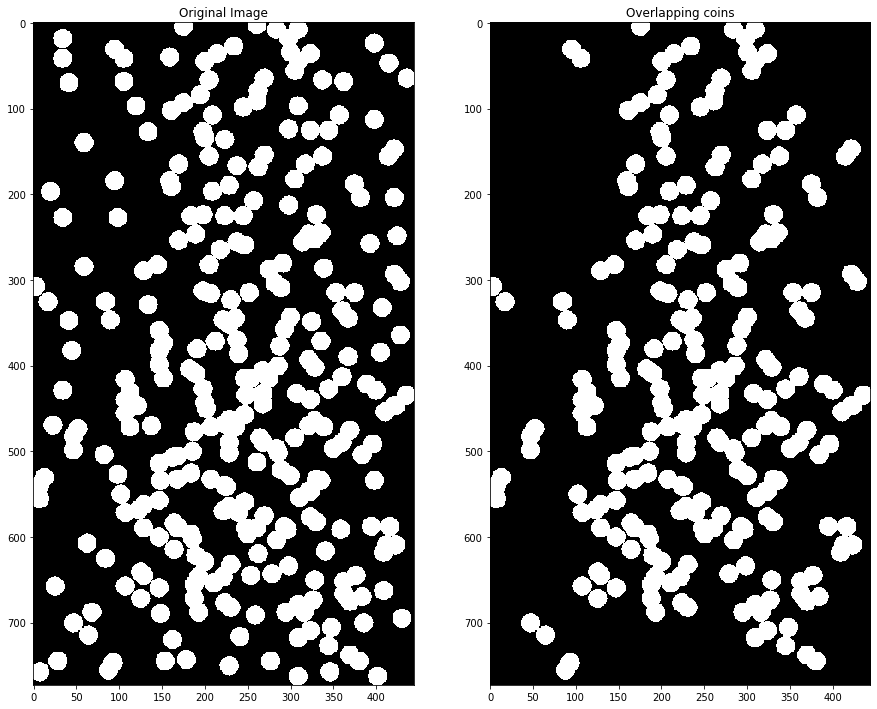

In [21]:
out_c = ret.copy()
out_s = ret.copy()

for i in labs:
    ind = np.where(ret == i)
    if len(ind[0]) > 400:
        out_c[ind] = thresh[ind[0][0]][ind[1][0]]
    else:
        out_s[ind] = thresh[ind[0][0]][ind[1][0]]

out_c = np.where(out_c == 1, 1, 0)
out_s = np.where(out_s == 1, 1, 0)
showImages(thresh, out_c, "Original Image", "Overlapping coins")

## Q3.3)

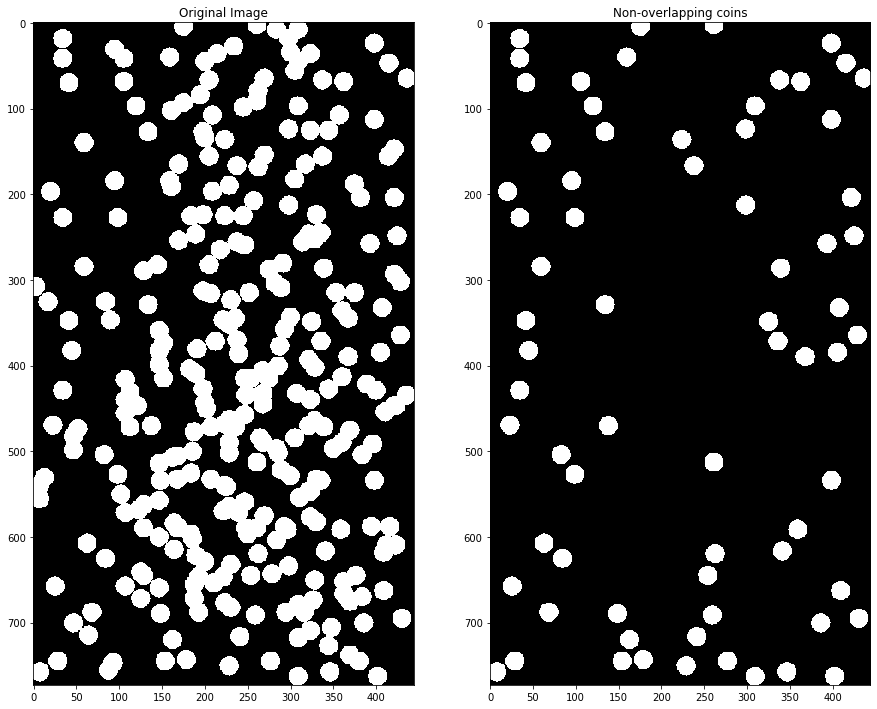

In [22]:
showImages(thresh, out_s, "Original Image", "Non-overlapping coins")

# Question 4

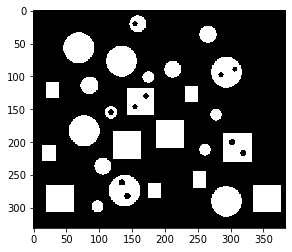

In [23]:
img = cv2.imread('./res/objects.png', 0)
thresh = np.uint8(np.where(img > 128, 1, 0))
plt.imshow(thresh, cmap='gray')
plt.show()

In [24]:
ret, labs = connected_components(thresh)
# print(labs.shape)
ret_inv, labs_inv = connected_components(thresh^1)
# print(labs_inv.shape)

## Part 1

No. of objects with one or more holes : 6


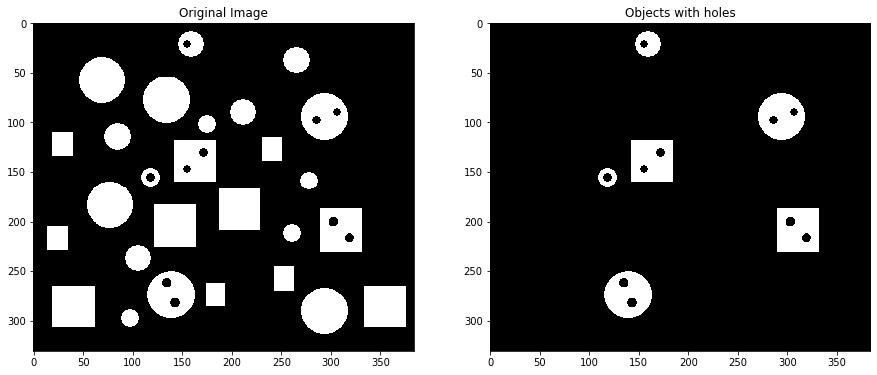

In [25]:
holes = []
for i in range(img.shape[0]):
    for j in range(1, img.shape[1]):
        if ret_inv[i][j] > 1 and ret_inv[i][j-1] == 0 and ret_inv[i][j] in labs_inv:
            if ret[i][j-1] not in holes:
                holes.append(ret[i][j-1])

out = np.zeros(ret.shape)
for i in holes:
    out[ret == i] = 1
print("No. of objects with one or more holes :", len(holes))
showImages(thresh, out, "Original Image", "Objects with holes")

## Part 2

No. of Square objects : 11


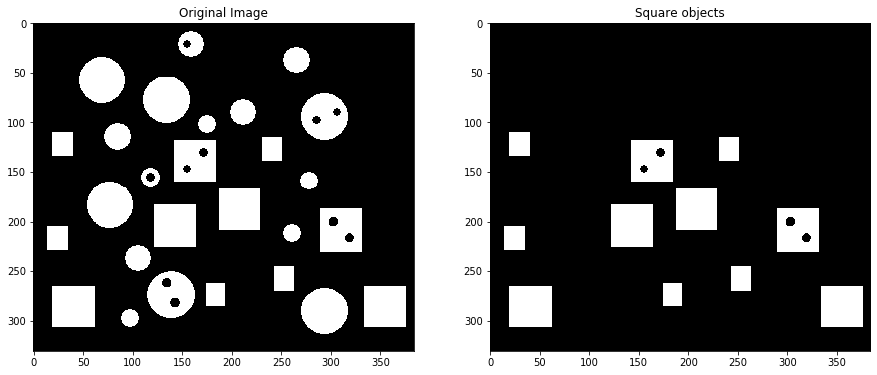

In [26]:
miss_kernel = [[1, 1, 1], [1, 0, 0],[1, 0, 0]]
hit_kernel = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
squares = []

for i in labs:
    if i == 0:
        continue
    ind = np.where(ret == i)
    for l in range(len(ind[0])):
        j = ind[0][l]
        k = ind[1][l]
        if j > 0 and j < ret.shape[0] - 1 and k > 0 and k < ret.shape[1] - 1:
            v1 = np.sum(np.multiply(thresh[j-1:j+2, k-1:k+2], miss_kernel))
            v2 = np.sum(np.multiply(thresh[j-1:j+2, k-1:k+2], hit_kernel))
            if v1 == 0 and v2 == np.sum(hit_kernel):
                squares.append(i)
                break

out = np.zeros(ret.shape)
for i in squares:
    out[ret == i] = 1
print("No. of Square objects :", len(squares))
showImages(thresh, out, "Original Image", "Square objects")

No. of Circular objects : 16


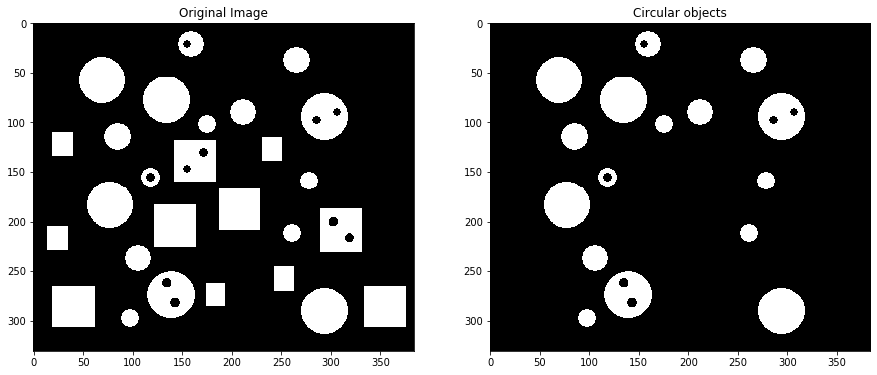

In [27]:
circles = np.setdiff1d(np.array(labs), np.array(squares))
circles = np.setdiff1d(circles, np.array([0]))

out = np.zeros(ret.shape)
for i in circles:
    out[ret == i] = 1

print("No. of Circular objects :", len(circles))
showImages(thresh, out, "Original Image", "Circular objects")

## Part 3

No. of square objects with holes : 2


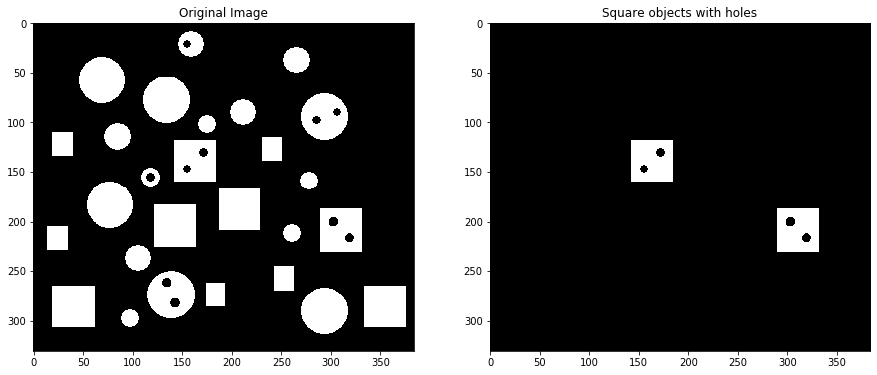

In [28]:
out = np.zeros(ret.shape)
hole_sq = 0
for i in squares:
    if i in holes:
        hole_sq += 1
        out[ret == i] = 1
print("No. of square objects with holes :", hole_sq)
showImages(thresh, out, "Original Image", "Square objects with holes")

## Part 4

No. of circular objects without holes : 12


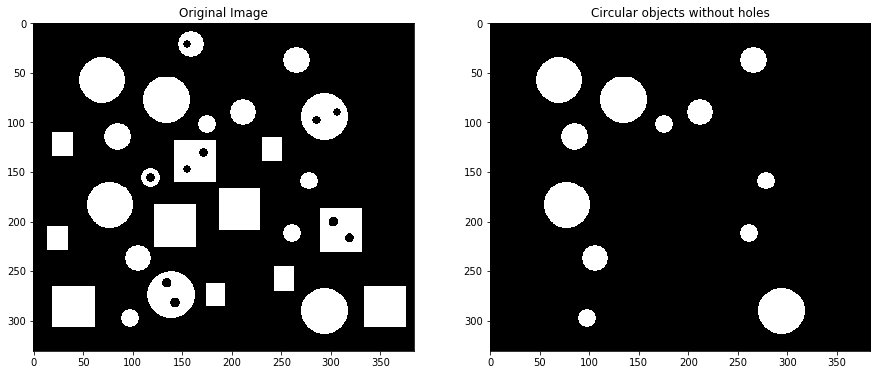

In [29]:
out = np.zeros(ret.shape)
nohole_circ = 0
for i in circles:
    if i not in holes:
        nohole_circ += 1
        out[ret == i] = 1
print("No. of circular objects without holes :", nohole_circ)
showImages(thresh, out, "Original Image", "Circular objects without holes")

# Question 5

## Part 1

In [30]:
img = cv2.imread('./res/text.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
colors = []
color_d = {}
img = img[20:-20, 20:-20]
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if list(img[i][j]) not in colors:
            colors.append(list(img[i][j]))
            color_d[tuple(list(img[i][j]))] = 0
        color_d[tuple(list(img[i][j]))] += 1

ct = []
for i in colors:
    ct.append(color_d[tuple(i)])

ind = np.argsort(ct)[::-1]
colors = np.array(colors)
final_colors = colors[ind[1:6]]
back_color = colors[ind[0]]
print(final_colors)

[[ 31  73 125]
 [255   0   0]
 [  0 176  80]
 [  0   0   0]
 [112  48 160]]


In [31]:
images = []
for col in final_colors:
    new_img = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j][0] == col[0] and img[i][j][1] == col[1] and img[i][j][2] == col[2]:
                new_img[i][j] = 1
#     plt.imshow(new_img, 'gray')
#     plt.figure()
    images.append(new_img)

In [32]:
connected_imgs = []
for idx, ima in enumerate(images):
    ret, labs = connected_components(ima)
    connected_imgs.append(ret)
    print("Color :", final_colors[idx], "Number of connected components =", len(labs))

Color : [ 31  73 125] Number of connected components = 28
Color : [255   0   0] Number of connected components = 25
Color : [  0 176  80] Number of connected components = 75
Color : [0 0 0] Number of connected components = 242
Color : [112  48 160] Number of connected components = 35


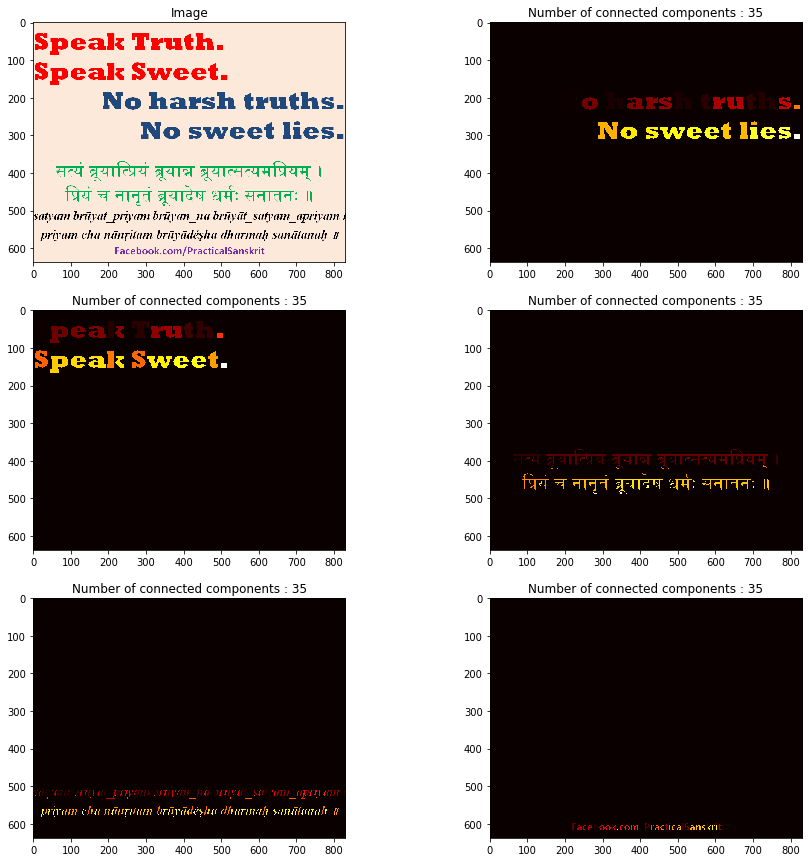

In [33]:
arr = plt.subplots(3, 2, figsize =(15,15))[1]
arr[0][0].imshow(img, cmap = 'gray')
arr[0][0].set_title('Image')

for idx in range(len(final_colors)):
    arr[(idx+1)//2][(idx+1)%2].imshow(connected_imgs[idx], cmap='hot')
    arr[(idx+1)//2][(idx+1)%2].set_title("Number of connected components : " + str(len(labs)))
plt.show()

## Part 2

In [34]:
colors = [[255, 0, 0],
          [0, 255, 0],
          [0, 0, 255],
          [255, 255, 0],
          [255, 0, 255],
          [0, 255, 255],
          [31, 73, 125], 
          [0, 176, 80], 
          [112, 48, 160]]

In [35]:
def get_holes(img, nh):
    ret, labs = connected_components(thresh)
    ret_inv, labs_inv = connected_components(thresh^1)
    holes = []
    holes_d = {}
    nh += 1
    for i in range(img.shape[0]):
        for j in range(1, img.shape[1]):
            if ret_inv[i][j] > 1 and ret_inv[i][j-1] == 0 and ret_inv[i][j] in labs_inv:
                if ret[i][j-1] not in holes:
                    holes.append(ret[i][j-1])
                    holes_d[ret[i][j-1]] = []
                if ret_inv[i][j] not in holes_d[ret[i][j-1]]:
                    holes_d[ret[i][j-1]].append(ret_inv[i][j])
    
    out = np.zeros((img.shape[0], img.shape[1], 3))
    for idx, i in enumerate(holes):
        if len(holes_d[i]) == nh:
            ind = np.where(ret == i)
            out[ind] = colors[idx%9]
    return out

## 1st Image

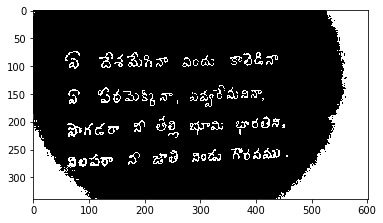

In [36]:
img = cv2.imread('./res/img1.jpeg', 0)
thresh = np.where(img < 100, 1, 0)
# thresh = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,25, 25)
plt.imshow(thresh, 'gray')
plt.show()

In [37]:
out1 = get_holes(thresh, 1)
out2 = get_holes(thresh, 2)

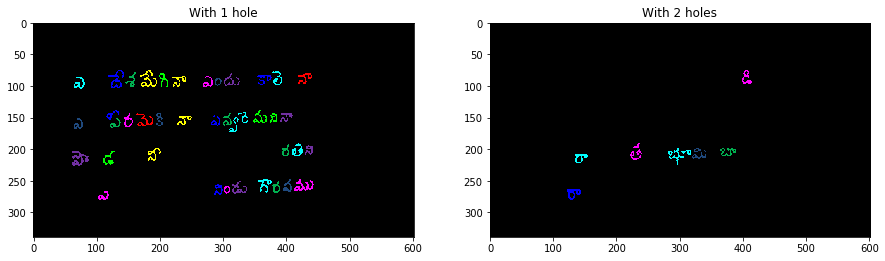

In [38]:
arr = plt.subplots(1,2, figsize =(15,15))[1]
arr[0].imshow(np.uint8(out1))
arr[0].set_title("With 1 hole")
arr[1].imshow(np.uint8(out2))
arr[1].set_title("With 2 holes")
plt.show()

## 2nd Image

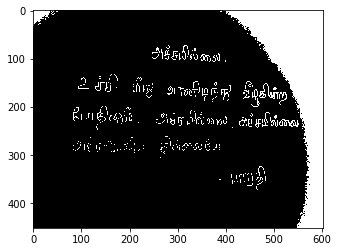

In [39]:
img = cv2.imread('./res/img2.jpeg', 0)
thresh = np.where(img < 205, 1, 0)
# thresh = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,25, 25)
plt.imshow(thresh, 'gray')
plt.show()

In [40]:
out1 = get_holes(thresh, 1)
out2 = get_holes(thresh, 2)

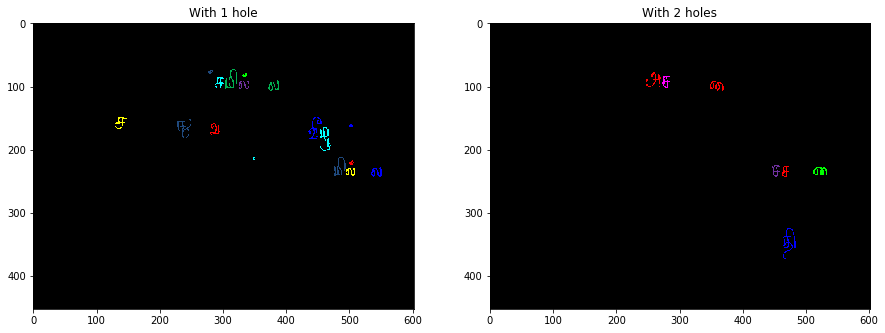

In [41]:
arr = plt.subplots(1,2, figsize =(15,15))[1]
arr[0].imshow(np.uint8(out1))
arr[0].set_title("With 1 hole")
arr[1].imshow(np.uint8(out2))
arr[1].set_title("With 2 holes")
plt.show()